Before moving to more powerful GPUs, try training for a few hours similar to challenge 19, but on 2 GPUs and with evaluating core metrics and logging to wandb along the way.

First try a short run

Get WANDB_API_KEY into environment

In tmux shell:

```
source .venv/bin/activate

cd challenge-24-train-for-hours-on-two-gpus

torchrun --standalone --nproc_per_node=2 -m scripts.my_base_train -- --depth=12 --max_seq_len=1000 --device_batch_size=3 --num_iterations=1000 --total_batch_size=6000 --eval_every=100 --eval_tokens=18000 --core_metric_every=50 --core_metric_max_per_task=100 --run=challenge-24-1 > train_output_001.txt 2>&1

```

In [3]:
!tail -100 train_output_001.txt

step 00035/01000 (3.50%) | loss: 7.450606 | grad norm: 2.1000 | lrm: 1.00 | dt: 1127.33ms | tok/sec: 5,322 | mfu: -1.00 | total time: 0.46m
step 00036/01000 (3.60%) | loss: 7.414587 | grad norm: 2.6385 | lrm: 1.00 | dt: 1125.92ms | tok/sec: 5,328 | mfu: -1.00 | total time: 0.48m
step 00037/01000 (3.70%) | loss: 7.412595 | grad norm: 1.5746 | lrm: 1.00 | dt: 1127.75ms | tok/sec: 5,320 | mfu: -1.00 | total time: 0.50m
step 00038/01000 (3.80%) | loss: 7.413905 | grad norm: 2.7500 | lrm: 1.00 | dt: 1130.33ms | tok/sec: 5,308 | mfu: -1.00 | total time: 0.52m
step 00039/01000 (3.90%) | loss: 7.371804 | grad norm: 3.3807 | lrm: 1.00 | dt: 1129.28ms | tok/sec: 5,313 | mfu: -1.00 | total time: 0.54m
step 00040/01000 (4.00%) | loss: 7.358074 | grad norm: 2.1841 | lrm: 1.00 | dt: 1130.84ms | tok/sec: 5,305 | mfu: -1.00 | total time: 0.56m
step 00041/01000 (4.10%) | loss: 7.334646 | grad norm: 2.1036 | lrm: 1.00 | dt: 1130.79ms | tok/sec: 5,306 | mfu: -1.00 | total time: 0.57m
step 00042/01000 (4.

Fixed. Also lower max per task because it's slow.

```
torchrun --standalone --nproc_per_node=2 -m scripts.my_base_train -- --depth=12 --max_seq_len=1000 --device_batch_size=3 --num_iterations=1000 --total_batch_size=6000 --eval_every=100 --eval_tokens=18000 --core_metric_every=50 --core_metric_max_per_task=20 --run=challenge-24-2 > train_output_002.txt 2>&1

```

Going to interrupt because seems to be working correctly including logging to wandb, but I want to run a quick one all the way to saving the checkpoint before letting a longer one run for a while.

In [4]:
!tail -10 train_output_002.txt

    self._close(death_sig=death_sig, timeout=timeout)
  File "/home/paperspace/nanogpt-learning/.venv/lib/python3.10/site-packages/torch/distributed/elastic/multiprocessing/api.py", line 920, in _close
    handler.proc.wait(time_to_wait)
  File "/usr/lib/python3.10/subprocess.py", line 1209, in wait
    return self._wait(timeout=timeout)
  File "/usr/lib/python3.10/subprocess.py", line 1953, in _wait
    time.sleep(delay)
  File "/home/paperspace/nanogpt-learning/.venv/lib/python3.10/site-packages/torch/distributed/elastic/multiprocessing/api.py", line 85, in _terminate_process_handler
    raise SignalException(f"Process {os.getpid()} got signal: {sigval}", sigval=sigval)
torch.distributed.elastic.multiprocessing.api.SignalException: Process 8776 got signal: 2


Good to see wandb shows it as killed:

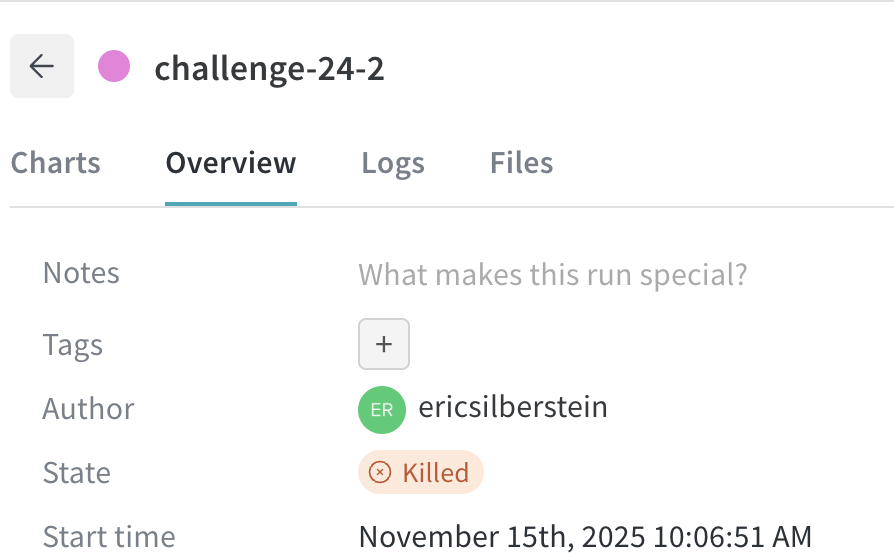

```
torchrun --standalone --nproc_per_node=2 -m scripts.my_base_train -- --depth=12 --max_seq_len=1000 --device_batch_size=3 --num_iterations=100 --total_batch_size=6000 --eval_every=10 --eval_tokens=18000 --core_metric_every=50 --core_metric_max_per_task=20 --run=challenge-24-3 > train_output_003.txt 2>&1

```

There are a lot of nice charts in wandb and they seem to suggest we're saturating the GPUs as we want

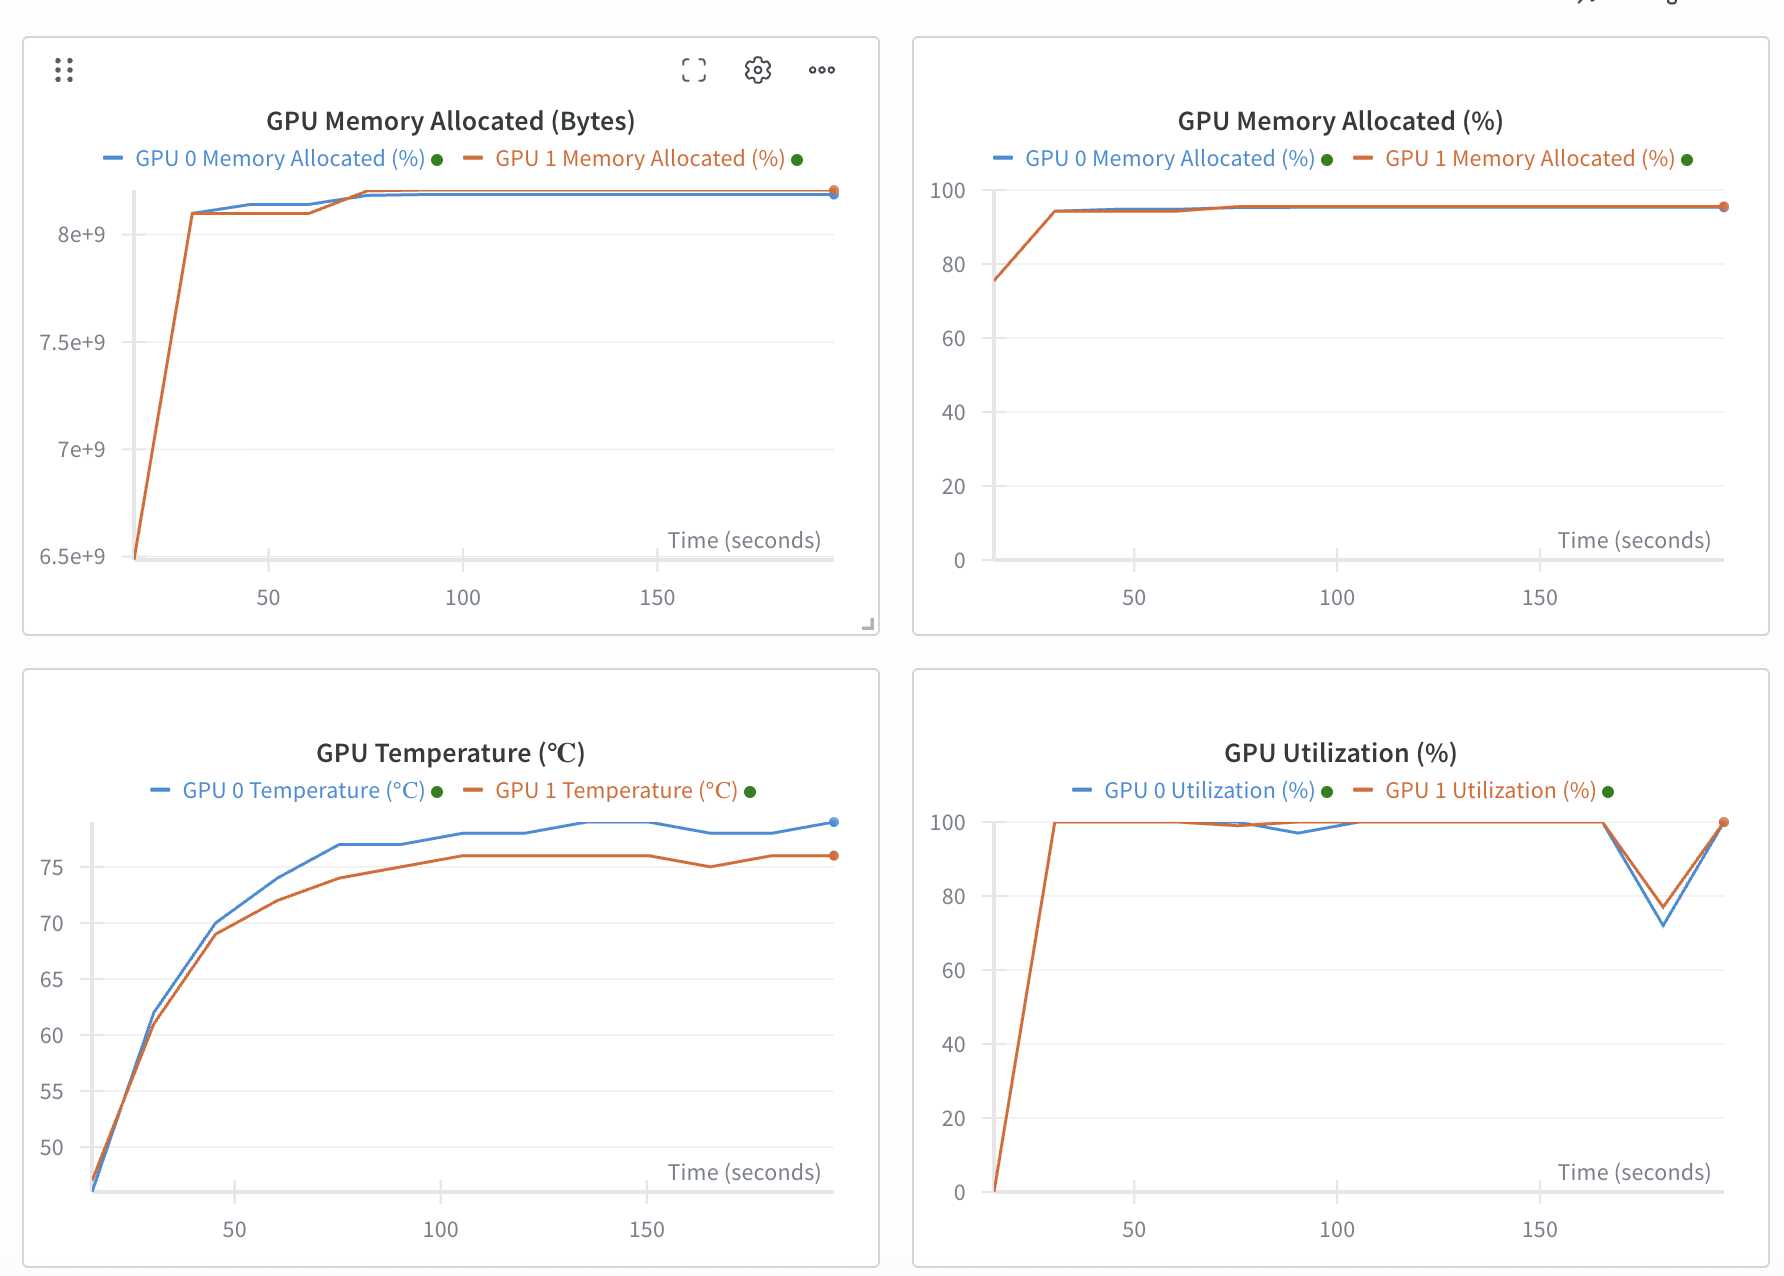

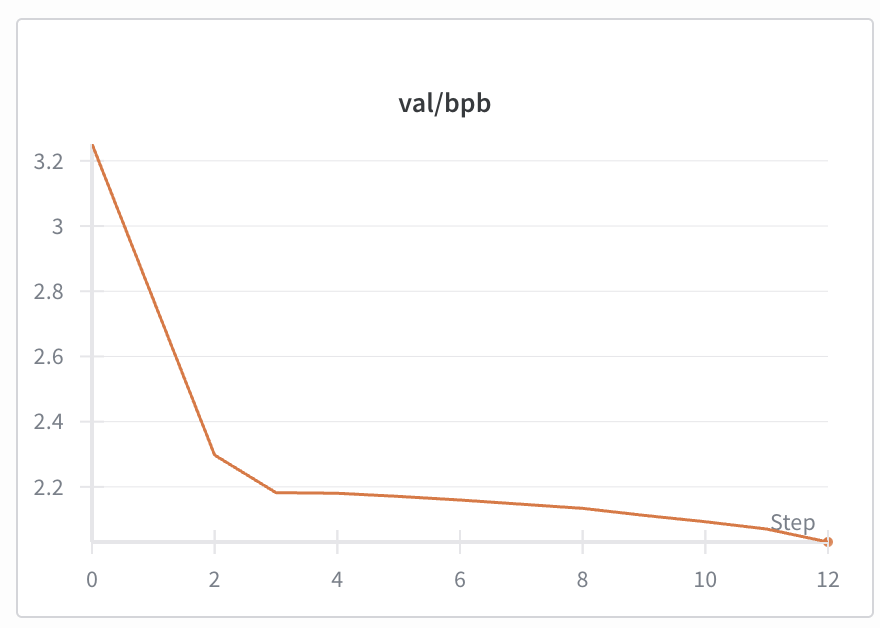

Run finished, make sure we can load the checkpoint.

In [8]:
!grep "saved model" train_output_003.txt

saved model to /home/paperspace/.cache/my_nanochat/base_checkpoints/d12/model_000100.pt


In [10]:
import sys
sys.path.append('../my_nanochat')
import os
import torch
from my_nanochat.my_common import get_base_dir, autodetect_device_type
from my_nanochat.my_checkpoint_manager import build_model
device_type = autodetect_device_type()
device = torch.device(device_type)
autocast_ctx = torch.amp.autocast(device_type=device_type, dtype=torch.bfloat16) if device_type == "cuda" else nullcontext()

Autodetected device type: cuda


In [11]:
checkpoint_dir = os.path.join(get_base_dir(), "base_checkpoints", "d12")
model, tokenizer, meta_data = build_model(checkpoint_dir, step=100, device=device, phase="eval")

Building model with config: {'sequence_len': 1000, 'vocab_size': 65536, 'n_layer': 12, 'n_head': 6, 'n_kv_head': 6, 'n_embd': 768}


In [12]:
model

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(65536, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (attn): CausalSelfAttention(
          (c_q): Linear(in_features=768, out_features=768, bias=False)
          (c_k): Linear(in_features=768, out_features=768, bias=False)
          (c_v): Linear(in_features=768, out_features=768, bias=False)
          (c_proj): Linear(in_features=768, out_features=768, bias=False)
        )
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=False)
          (c_proj): Linear(in_features=3072, out_features=768, bias=False)
        )
      )
    )
  )
  (lm_head): Linear(in_features=768, out_features=65536, bias=False)
)

In [15]:
with autocast_ctx:
    tokens = list(model.generate(tokenizer.encode("Hello", prepend=tokenizer.get_bos_token_id()), max_tokens=10))
tokens

[5385, 345, 1027, 64464, 2243, 1829, 372, 11514, 44, 550]

In [16]:
tokenizer.decode(tokens)

' behaviour are good Lond provides business (front, one'

### few hour run

ok, let's run for around 4 hours

In [18]:
4 * 60 * 60 * 1000 // 1160

12413

restart kernel so jupyter isn't holding onto GPU memory

```
torchrun --standalone --nproc_per_node=2 -m scripts.my_base_train -- --depth=12 --max_seq_len=1000 --device_batch_size=3 --num_iterations=12000 --total_batch_size=6000 --eval_every=100 --eval_tokens=18000 --core_metric_every=1000 --core_metric_max_per_task=50 --sample_every=500 --run=challenge-24-4 > train_output_004.txt 2>&1
```

Completed.

In [5]:
!tail -40 train_output_004.txt

<|bos|>The planets of the solar system are: the sun, the sun, the sun, the
<|bos|>My favorite color is the name of the name of the name of the
<|bos|>If 5*x + 3 = 13, then x is 1.5, then x is 1
saved model to /home/paperspace/.cache/my_nanochat/base_checkpoints/d12/model_012000.pt
saved metadata to /home/paperspace/.cache/my_nanochat/base_checkpoints/d12/meta_012000.json
saved optimizer to /home/paperspace/.cache/my_nanochat/base_checkpoints/d12/optim_012000_rank0.pt
Peak memory usage: 7327.61MiB
Total training time: 230.11m
Minimum validation bpb: 1.3442
wandb: uploading history steps 252-252, summary, console lines 12608-12618; updating run metadata
wandb: uploading summary, console lines 12619-12622
wandb: 
wandb: Run history:
wandb:         core_metric ▂▁▄▇▂▁▃▇▃▄██
wandb:                step ▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
wandb: total_training_time ▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
wandb:            train/dt ▃▃▃▃▂▂▃▃█▂▁▃▂▃▂▃▃▃▃▃▃▂▃▃▃▃▁▃▃▃▄▂▃▃▁▃▃▃▃▃
wandb:     train

Looks like training was was well-behaved from these charts. Not sure if the spike in grad_norm is a concern.

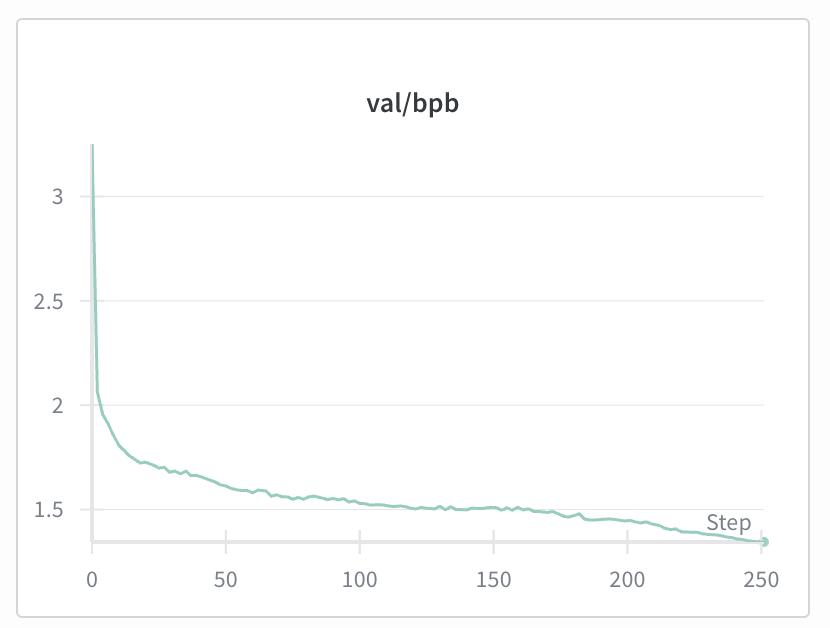

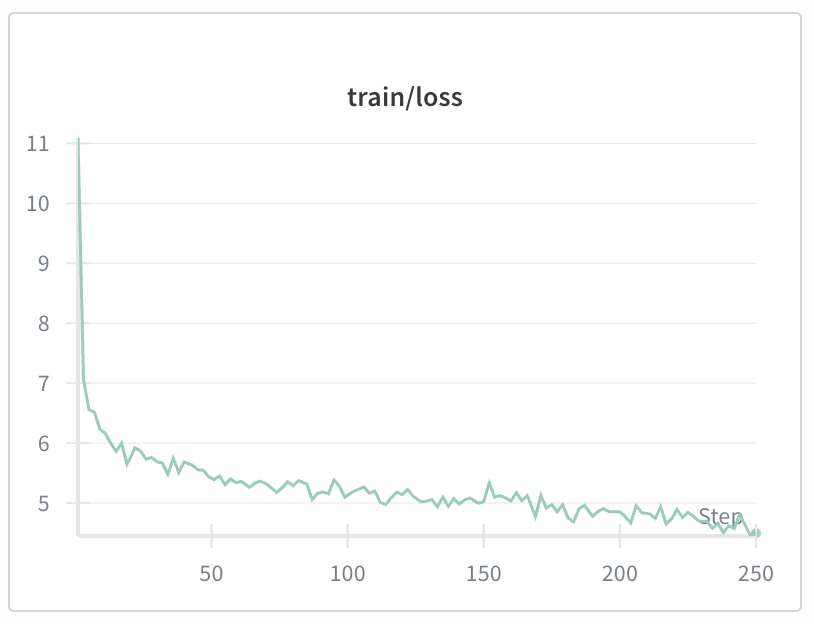

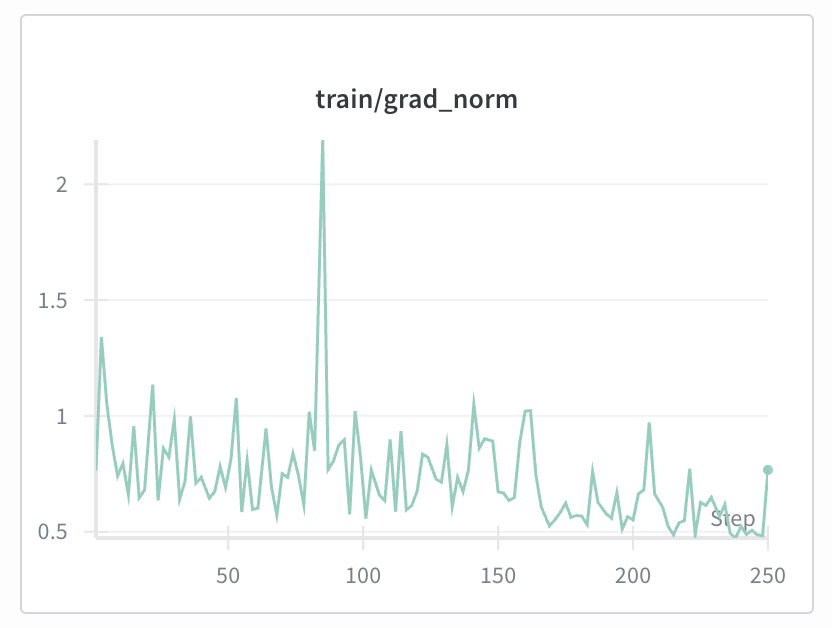

In [11]:
!grep "France" -A 7 train_output_004.txt

<|bos|>The capital of France is the most important part of the United States. The
<|bos|>The chemical symbol of gold is a very important part of the air pollution. The
<|bos|>If yesterday was Friday, then tomorrow will be a company of a company to be able to be
<|bos|>The opposite of hot is a common cause of the body. The body is
<|bos|>The planets of the solar system are: the most important thing is that the “the “
<|bos|>My favorite color is a very important and effective. The most common is
<|bos|>If 5*x + 3 = 13, then x is 200. The first 2000 is
step 00500/12000 (4.17%) | loss: 6.160216 | grad norm: 0.7950 | lrm: 1.00 | dt: 1133.24ms | tok/sec: 5,294 | mfu: -1.00 | total time: 9.35m
--
<|bos|>The capital of France is a high priest. The 19th Day is
<|bos|>The chemical symbol of gold is a high priest. The first day of the 
<|bos|>If yesterday was Friday, then tomorrow will be a lot of people and their friends. The first
<|bos|>The opposite of hot is a very good choice to be a good ch

^ At quick glance samples from later don't look especially better or worse than from earlier.

In [12]:
import sys
sys.path.append('../my_nanochat')
import os
import torch
from my_nanochat.my_common import get_base_dir, autodetect_device_type
from my_nanochat.my_checkpoint_manager import build_model
device_type = autodetect_device_type()
device = torch.device(device_type)
autocast_ctx = torch.amp.autocast(device_type=device_type, dtype=torch.bfloat16) if device_type == "cuda" else nullcontext()

Autodetected device type: cuda


In [13]:
checkpoint_dir = os.path.join(get_base_dir(), "base_checkpoints", "d12")
model, tokenizer, meta_data = build_model(checkpoint_dir, step=12000, device=device, phase="eval")

Building model with config: {'sequence_len': 1000, 'vocab_size': 65536, 'n_layer': 12, 'n_head': 6, 'n_kv_head': 6, 'n_embd': 768}


In [17]:
with autocast_ctx:
    tokens = list(model.generate(tokenizer.encode("First take a right on Main St.", prepend=tokenizer.get_bos_token_id()), max_tokens=10))
tokens

[24504, 50847, 400, 311, 2229, 353, 257, 1990, 281, 784]

In [18]:
tokenizer.decode(tokens)

' Petersburg ohms can be associated with a range of health'